## 1. Twitter Data Scraping and Cleaning


### Importing Required Libraries


In [6]:
import re
import unicodedata
import pandas as pd
import snscrape.modules.twitter as sntwitter


### Defining Function to Remove Emojis and Hashtags


In [7]:
def remove_emojis_and_hashtags(text: str) -> str:
    text_without_emojis = ''.join(
        c for c in text if not unicodedata.category(c).startswith('So'))
    text_without_hashtags = re.sub(r'#\S+', '', text_without_emojis)
    return text_without_hashtags


### Setting Query and Limit

The query is designed to find tweets containing the term "ramadan" within the date range of 1/1/2023 to 4/18/2023.


In [17]:
query = "ramadan until:2023-04-18 since:2023-01-01"
tweets = []
limit = 100000


### Scraping 100,000 Tweets and Processing Text

This code processes tweets by removing mentions (e.g., @user), URLs, emojis, and hashtags. If a tweet consists only of these elements, the processed tweet will be empty.


In [9]:
for tweet in sntwitter.TwitterSearchScraper(query).get_items():

    if len(tweets) == limit:
        break
    else:
        processed_tweet = [t for t in tweet.rawContent.split(
        ) if not t.startswith('@') and not t.startswith('http')]
        processed_tweet = ' '.join(processed_tweet)
        processed_tweet = remove_emojis_and_hashtags(processed_tweet)

        tweets.append([tweet.date, tweet.user.username, processed_tweet])


Tweet 1645781998559014912 contains an app icon medium key '4_1648179041923665921' on app 'android_app'/'com.bodyfast', but the corresponding medium is missing; dropping
Tweet 1645781998559014912 contains an app icon medium key '4_1648238562654179330' on app 'iphone_app'/'1189568780', but the corresponding medium is missing; dropping
Tweet 1645781998559014912 contains an app icon medium key '4_1648238562654179330' on app 'ipad_app'/'1189568780', but the corresponding medium is missing; dropping


### Creating DataFrame and Saving to CSV


In [10]:
df = pd.DataFrame(tweets, columns=['Date', 'User', 'Tweet'])

# save to csv
df.to_csv('./tweets.csv')


# 2. Tweets Word Count Analysis with PySpark

Utilizing PySpark for a Tweets Word Count Analysis enables parallel and distributed computing, efficiently processing large datasets across multiple nodes in a cluster. This feature enhances scalability, performance, and fault tolerance, making it a powerful choice for analyzing extensive tweet data.


### Importing Required Libraries


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, size


### Initializing Spark Session


In [3]:
spark = SparkSession.builder.appName(
    "Spark_Word_Count").master("local[*]").getOrCreate()


### Reading CSV File into DataFrame


In [4]:
df = spark.read.csv("tweets.csv", header=True)


### Splitting Tweet Text into Words and Counting Words per Tweet

This code processes a DataFrame containing tweets by splitting the content into words and counting the number of words in each tweet. If a tweet is empty, the word count for that tweet will be set to -1, indicating that the processed tweet contains no words.


In [5]:
word_count = split(df["Tweet"], " ")
df = df.withColumn("word_count", size(word_count))


### Displaying DataFrame and Saving to CSV


In [6]:
df.show()

# Saving DataFrame to different CSV File
df.toPandas().to_csv("tweets_word_count.csv")

# Saving DataFrame to the same CSV File
# df.toPandas().to_csv("tweets.csv")


+---+--------------------+---------------+--------------------+----------+
|_c0|                Date|           User|               Tweet|word_count|
+---+--------------------+---------------+--------------------+----------+
|  0|2023-04-17 23:59:...|   Uzair__tariq|29 اور 30 رمضان ا...|        39|
|  1|2023-04-17 23:59:...|     itznotaiza|IM GOOD JUST RLLY...|        15|
|  2|2023-04-17 23:59:...|Ramadan44999295|                   ️|         1|
|  3|2023-04-17 23:59:...|          9r2_x|لا لا لبعد رمضان ...|        19|
|  4|2023-04-17 23:59:...|   art_consoles|                null|        -1|
|  5|2023-04-17 23:59:...|  Monia_Ramadan|اللّهم إنّك عفوٌ ...|         7|
|  6|2023-04-17 23:59:...|          N50D9|             ٢٧رمضان|         2|
|  7|2023-04-17 23:59:...|     thebimbimm|27th night of Ram...|        17|
|  8|2023-04-17 23:59:...|         fa0zx1|         27 Ramadan |         3|
|  9|2023-04-17 23:59:...|Ramadan70530344|War Ridwaanka Waa...|         8|
| 10|2023-04-17 23:59:...

# 3. Analyzing and Visuallizing data


### Importing Required Libraries


In [7]:
import matplotlib.pyplot as plt
import pandas as pd


### Count the occurrence of word_count


In [8]:
word_count_occurrence = df.groupBy(
    "word_count").count().orderBy("word_count").collect()


### Get summary statistics for word_count_occurrence


In [9]:
def display_word_count_summary(df):
    _df = pd.DataFrame(word_count_occurrence, columns=["word_count", "count"])
    summary = _df["word_count"].describe()
    print("Tweets_Word_Count Summary:")
    print(f"Count: {summary['count']}")
    if summary["min"] == -1:
        print(f"Minimum: {summary['min']} (Empty preprocessed tweet)")
    else:
        print(f"Minimum: {summary['min']}")
    print(f"Maximum: {summary['max']}")
    print(f"Mean: {summary['mean']:.2f}")
    print(f"Standard Deviation: {summary['std']:.2f}")
    print(f"25th Percentile: {summary['25%']}")
    print(f"50th Percentile (Median): {summary['50%']}")
    print(f"75th Percentile: {summary['75%']}")


display_word_count_summary(df)


Tweets_Word_Count Summary:
Count: 71.0
Minimum: -1.0 (Empty preprocessed tweet)
Maximum: 79.0
Mean: 35.13
Standard Deviation: 20.93
25th Percentile: 17.5
50th Percentile (Median): 35.0
75th Percentile: 52.5


### Extract word counts and their occurrences


In [10]:
word_counts = [row["word_count"] for row in word_count_occurrence]
occurrences = [row["count"] for row in word_count_occurrence]


### Display word_count_occurrence in a Scatter Plot graph


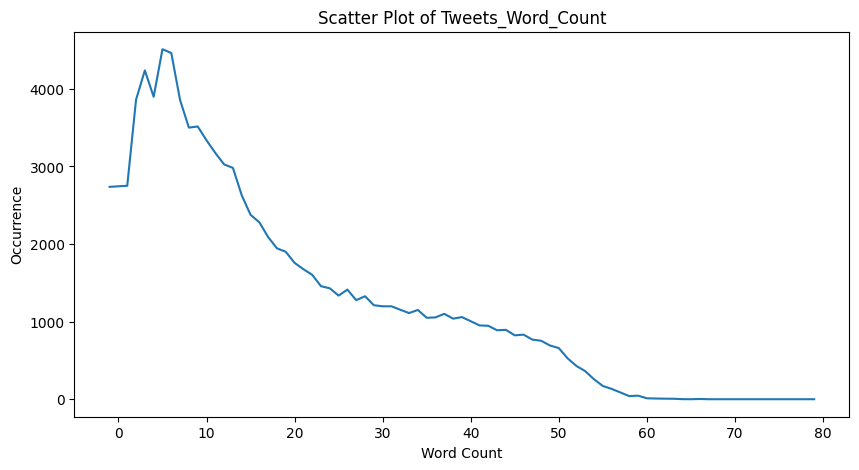

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(word_counts, occurrences)
plt.xlabel("Word Count")
plt.ylabel("Occurrence")
plt.title("Scatter Plot of Tweets_Word_Count")
plt.show()


### Display word_count_occurrence in a Bar Chart


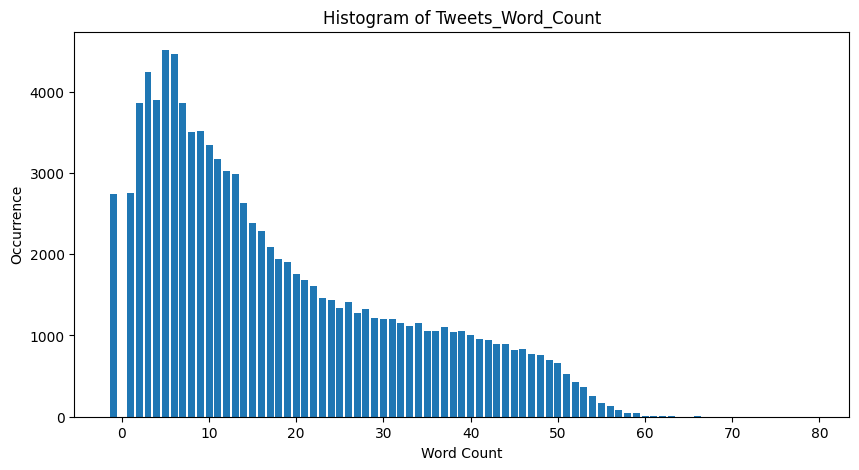

In [12]:
plt.figure(figsize=(10, 5))
plt.bar(word_counts, occurrences)
plt.xlabel("Word Count")
plt.ylabel("Occurrence")
plt.title("Histogram of Tweets_Word_Count")
plt.show()


### Display word_count_occurrence in a Bar Chart (Log Scale)


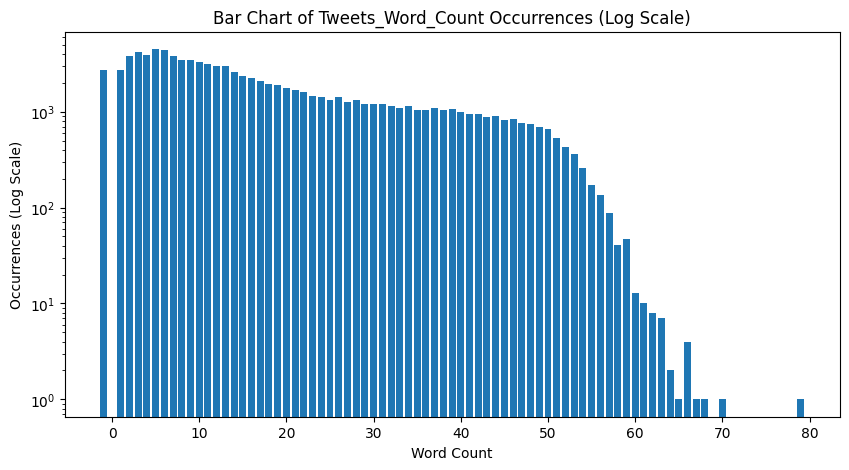

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(word_counts, occurrences, log=True)
plt.xlabel("Word Count")
plt.ylabel('Occurrences (Log Scale)')
plt.title('Bar Chart of Tweets_Word_Count Occurrences (Log Scale)')
plt.show()


### Pie Chart of Top 15 Word Count Occurrences


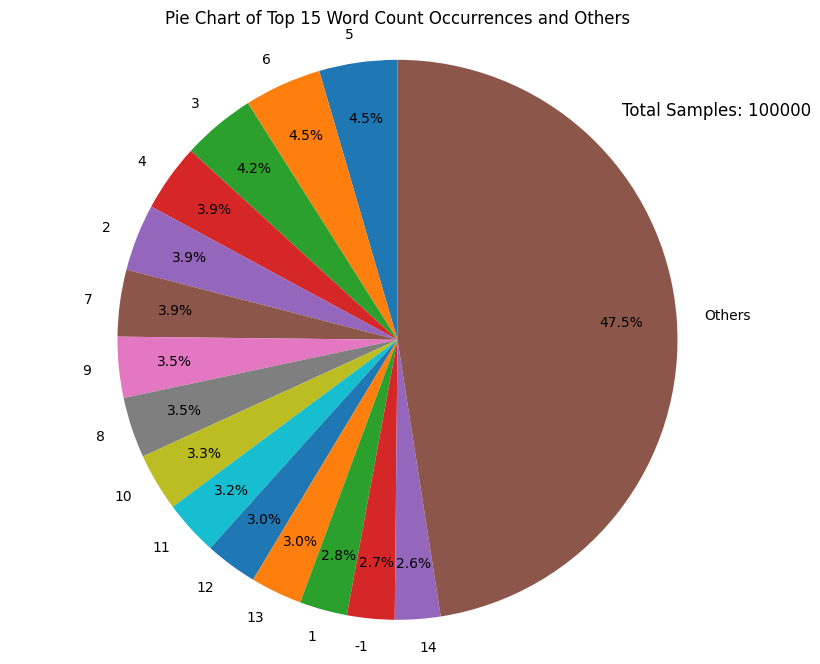

In [18]:
# Sort the data based on occurrences in descending order
sorted_data = sorted(zip(word_counts, occurrences),
                     key=lambda x: x[1], reverse=True)

# Extract the top N word counts and their occurrences
top_n = 15
top_word_counts = [x[0] for x in sorted_data[:top_n]]
top_occurrences = [x[1] for x in sorted_data[:top_n]]

# Calculate the sum of the remaining occurrences
remaining_occurrences = sum(x[1] for x in sorted_data[top_n:])

# Add an "Others" category for the remaining occurrences
if remaining_occurrences > 0:
    top_word_counts.append('Others')
    top_occurrences.append(remaining_occurrences)

plt.figure(figsize=(10, 8))
plt.pie(top_occurrences, labels=top_word_counts,
        autopct='%1.1f%%', startangle=90, pctdistance=0.8)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.title('Pie Chart of Top {} Word Count Occurrences and Others'.format(top_n))
plt.annotate(f'Total Samples: {limit}', xy=(
    0, 0), xytext=(0.8, 0.8), fontsize=12)
plt.show()
